# Final Project 
## IST 664 - Natural Language Processing
## Sentiment Analysis of Movie Reviews

### Exploratory Data Analysis

In [5]:
#Read the data
import pandas as pd

file = 'train.tsv'

df = pd.read_csv(file, sep = '\t', header = 0)
print(df)

        PhraseId  SentenceId  \
0              1           1   
1              2           1   
2              3           1   
3              4           1   
4              5           1   
...          ...         ...   
156055    156056        8544   
156056    156057        8544   
156057    156058        8544   
156058    156059        8544   
156059    156060        8544   

                                                   Phrase  Sentiment  
0       A series of escapades demonstrating the adage ...          1  
1       A series of escapades demonstrating the adage ...          2  
2                                                A series          2  
3                                                       A          2  
4                                                  series          2  
...                                                   ...        ...  
156055                                          Hearst 's          2  
156056                          forced avuncula

In [116]:
#Checking for null values in the target column
df['Sentiment'].isnull().sum()

0

In [117]:
#Count of different sentiments
df['Sentiment'].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

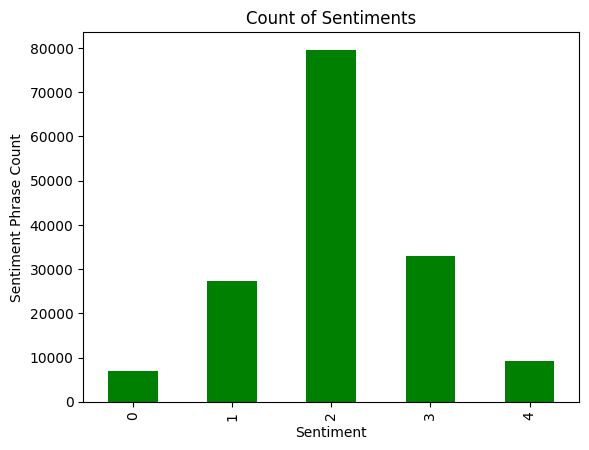

In [119]:
#Visualization of count of Sentiments
import matplotlib.pyplot as plt
%matplotlib inline
df['Sentiment'].value_counts().sort_index().plot(kind='bar', color= 'green')
plt.ylabel('Sentiment Phrase Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiments');

### Pre-processing of Data

In [6]:
#Load the libraries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [40]:
#Create a function to tokenize and keep only alphabetical words
def tokenize(text):
    tokens = [token.lower() for token in word_tokenize(text) if token.isalpha()]
    tokenized_text = ' '.join(tokens)
    return tokenized_text

In [42]:
#create a function to remove stop words
stop_words = stopwords.words('english')
stop_words.remove('not') #removing not from the stop_words list as it contains value in negative movie reviews
def remove_stop(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    stop_text = ' '.join(tokens)
    return stop_text

In [45]:
#Create a function for lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def wordnet_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha and token not in stop_words]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [50]:
#Create new columns for three different pre-processed texts
df['tokenized_text'] = df['Phrase'].apply(lambda Phrase: tokenize(Phrase))
df['stop_text'] = df['Phrase'].apply(lambda Phrase: remove_stop(Phrase))
df['lemmatized_text'] = df['Phrase'].apply(lambda Phrase: wordnet_lemmatization(Phrase))
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,tokenized_text,stop_text,lemmatized_text
0,1,1,a series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...,series escapades demonstrating adage good goos...,series escapade demonstrating adage good goose...
1,2,1,a series of escapades demonstrating the adage ...,2,a series of escapades demonstrating the adage ...,series escapades demonstrating adage good goose,series escapade demonstrating adage good goose
2,3,1,a series,2,a series,series,series
3,4,1,a,2,a,,
4,5,1,series,2,series,series,series
5,6,1,of escapades demonstrating the adage that what...,2,of escapades demonstrating the adage that what...,escapades demonstrating adage good goose,escapade demonstrating adage good goose
6,7,1,of,2,of,,
7,8,1,escapades demonstrating the adage that what is...,2,escapades demonstrating the adage that what is...,escapades demonstrating adage good goose,escapade demonstrating adage good goose
8,9,1,escapades,2,escapades,escapades,escapade
9,10,1,demonstrating the adage that what is good for ...,2,demonstrating the adage that what is good for ...,demonstrating adage good goose,demonstrating adage good goose


### Model Generation

In [56]:
#Create a function to extract bag-of-words features
from nltk.probability import FreqDist
def bag_of_words_features(tokens, top_words):
    freq_dist = FreqDist(tokens)
    top_words = [word for word, _ in freq_dist.most_common(top_words)]
    features = {word: (word in tokens) for word in top_words}
    return features

In [54]:
#Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.3, random_state = 7)

### Generating Model for just tokenized texts

In [70]:
#Extract bag-of-words features for the training set
top_words = 1000
train_features = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(train_data['tokenized_text'], train_data['Sentiment'])]

In [58]:
#Train the Naive-Bayes Classifier
from nltk.classify import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_features)

In [59]:
#Extract bag-of-words features for the testing set
test_features = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(test_data['tokenized_text'], test_data['Sentiment'])]

In [61]:
# Evaluate the classifier using precision, recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score
predicted_sentiments = [classifier.classify(features) for features, _ in test_features]
true_sentiments = [sentiment for _, sentiment in test_features]

precision = precision_score(true_sentiments, predicted_sentiments, average='weighted')
recall = recall_score(true_sentiments, predicted_sentiments, average='weighted')
f1 = f1_score(true_sentiments, predicted_sentiments, average='weighted')

In [103]:
# Display evaluation metrics
print("Precision:", "{:.2f}%".format(precision*100))
print("Recall:", "{:.2f}%".format(recall*100))
print("F1-Score:", "{:.2f}%".format(f1*100))

Precision: 45.56%
Recall: 14.29%
F1-Score: 12.31%


In [63]:
# Display confusion matrix
from nltk.metrics import ConfusionMatrix
conf_matrix = ConfusionMatrix(true_sentiments, predicted_sentiments)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
   |     0     1     2     3     4 |
--+-------------------------------+
0 |  <793>  153    16   264   898 |
1 |  2254  <680>  169  1891  3220 |
2 |  3092  2671 <1136>10843  6141 |
3 |  2285   655   164 <2642> 4109 |
4 |   734   115    25   428 <1440>|
--+-------------------------------+
(row = reference; col = test)



### Generating Model after removing stop words 

In [69]:
#Extract bag-of-words features for the training set
top_words = 1000
train_features_stop = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(train_data['stop_text'], train_data['Sentiment'])]

In [71]:
#Train the Naive-Bayes Classifier
classifier_stop = NaiveBayesClassifier.train(train_features_stop)

In [72]:
#Extract bag-of-words features for the testing set
test_features_stop = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(test_data['stop_text'], test_data['Sentiment'])]

In [94]:
# Evaluate the classifier using precision, recall, and F1-score
predicted_sentiments_stop = [classifier_stop.classify(features) for features, _ in test_features_stop]
true_sentiments_stop = [sentiment for _, sentiment in test_features_stop]

precision_stop = precision_score(true_sentiments_stop, predicted_sentiments_stop, average='weighted')
recall_stop = recall_score(true_sentiments_stop, predicted_sentiments_stop, average='weighted')
f1_stop = f1_score(true_sentiments_stop, predicted_sentiments_stop, average='weighted')

In [102]:
# Display evaluation metrics
print("Precision:", "{:.2f}%".format(precision_stop*100))
print("Recall:", "{:.2f}%".format(recall_stop*100))
print("F1-Score:", "{:.2f}%".format(f1_stop*100))

Precision: 47.53%
Recall: 14.33%
F1-Score: 12.96%


In [96]:
# Display confusion matrix
conf_matrix_stop = ConfusionMatrix(true_sentiments_stop, predicted_sentiments_stop)
print("Confusion Matrix:\n", conf_matrix_stop)

Confusion Matrix:
   |    0    1    2    3    4 |
--+--------------------------+
0 | <296>  87   21  215 1505 |
1 |  804 <399> 187 1722 5102 |
2 | 1324 1542<1587>9608 9822 |
3 |  789  302  187<2268>6309 |
4 |  188   43   27  324<2160>|
--+--------------------------+
(row = reference; col = test)



### Generating Model after Lemmatization

In [76]:
#Extract bag-of-words features for the training set
top_words = 1000
train_features_lemma = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(train_data['lemmatized_text'], train_data['Sentiment'])]

In [77]:
#Train the Naive-Bayes Classifier
classifier_lemma = NaiveBayesClassifier.train(train_features_lemma)

In [78]:
#Extract bag-of-words features for the testing set
test_features_lemma = [(bag_of_words_features(text, top_words), sentiment) for text, sentiment in zip(test_data['lemmatized_text'], test_data['Sentiment'])]

In [97]:
# Evaluate the classifier using precision, recall, and F1-score
predicted_sentiments_lemma = [classifier_lemma.classify(features) for features, _ in test_features_lemma]
true_sentiments_lemma = [sentiment for _, sentiment in test_features_lemma]

precision_lemma = precision_score(true_sentiments_lemma, predicted_sentiments_lemma, average='weighted')
recall_lemma = recall_score(true_sentiments_lemma, predicted_sentiments_lemma, average='weighted')
f1_lemma = f1_score(true_sentiments_lemma, predicted_sentiments_lemma, average='weighted')

In [101]:
# Display evaluation metrics
print("Precision:", "{:.2f}%".format(precision_lemma*100))
print("Recall:", "{:.2f}%".format(recall_lemma*100))
print("F1-Score:", "{:.2f}%".format(f1_lemma*100))

Precision: 51.77%
Recall: 13.35%
F1-Score: 11.43%


### Generating Model using LIWC sentiment lexicon features and also unigrams, bigrams and POS tags

In [81]:
#Import required library
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.corpus import opinion_lexicon

In [87]:
# Function to count positive and negative words using LIWC lexicon
#nltk.download('vader_lexicon')
def liwc_sentiment_feature(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    return {'pos_words': sentiment_scores['pos'], 'neg_words': sentiment_scores['neg']}

In [90]:
# Function to extract unigram, bigram, and POS tag features
#nltk.download('averaged_perceptron_tagger')
def combined_features(text):
    tokens = word_tokenize(text)
    unigrams = bag_of_words_features(tokens, top_words=1000)
    bigrams = bag_of_words_features(list(nltk.bigrams(tokens)), top_words=500)
    pos_tags = FreqDist([tag for _, tag in pos_tag(tokens)])
    
    features = {**unigrams, **bigrams, **pos_tags}
    return features

In [84]:
# Combine all features and LIWC sentiment feature
def all_features(text):
    liwc_features = liwc_sentiment_feature(text)
    text_features = combined_features(text)
    return {**text_features, **liwc_features}

In [91]:
# Extract features for the training set
train_features_all = [(all_features(text), sentiment) for text, sentiment in zip(train_data['stop_text'], train_data['Sentiment'])]

In [92]:
# Train the Naive Bayes classifier
classifier_all = NaiveBayesClassifier.train(train_features_all)

In [93]:
# Extract features for the testing set
test_features_all = [(all_features(text), sentiment) for text, sentiment in zip(test_data['stop_text'], test_data['Sentiment'])]

In [99]:
# Evaluate the classifier using precision, recall, and F1-score
predicted_sentiments_all = [classifier_all.classify(features) for features, _ in test_features]
true_sentiments_all = [sentiment for _, sentiment in test_features_all]

precision_all = precision_score(true_sentiments_all, predicted_sentiments_all, average='weighted')
recall_all = recall_score(true_sentiments_all, predicted_sentiments_all, average='weighted')
f1_all = f1_score(true_sentiments_all, predicted_sentiments_all, average='weighted')

In [100]:
# Display formatted metrics
print("Precision:", "{:.2f}%".format(precision_all * 100))
print("Recall:", "{:.2f}%".format(recall_all * 100))
print("F1-Score:", "{:.2f}%".format(f1_all * 100))

Precision: 36.44%
Recall: 22.05%
F1-Score: 24.04%
